<a href="https://www.kaggle.com/code/akscent/fitmlforcharn-prediction?scriptVersionId=154140571" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from catboost import CatBoostClassifier
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from pprint import pprint
from warnings import filterwarnings

import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px

filterwarnings("ignore", category=pd.errors.PerformanceWarning)
filterwarnings("ignore", category=FutureWarning)
filterwarnings("ignore", category=Warning)
filterwarnings("ignore", category=DeprecationWarning)

try:
    import cupy as cp
    gpu_available = True
except ImportError:
    gpu_available = False

n_jobs = -1 if gpu_available else 1

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load data

In [2]:
train_df = pd.read_csv('/kaggle/input/yandexcontest/train (2).csv')
test_df = pd.read_csv('/kaggle/input/yandexcontest/train (2).csv')
data = train_df
y_col = ["target"]

# x_train = pd.read_csv('/kaggle/input/sibalfahack/X_train_v1.csv')
# y_train = pd.read_csv('/kaggle/input/sibalfahack/y_train_v1.csv')
# test_df = pd.read_csv('/kaggle/input/sibalfahack/test_v1 (2).csv')
# y_cols = ["target"]
# data = x_train
# data[y_cols] = y_train

In [3]:
# num_cols = [
#        'sum_b_oper_3m', 'cnt_b_oper_3m', 'sum_c_oper_3m', 'cnt_c_oper_3m',
#        'sum_deb_d_oper_3m', 'cnt_deb_d_oper_3m', 'sum_cred_d_oper_3m',
#        'cnt_cred_d_oper_3m', 'sum_deb_e_oper_3m', 'cnt_deb_e_oper_3m',
#        'cnt_days_deb_e_oper_3m', 'sum_cred_e_oper_3m', 'cnt_cred_e_oper_3m',
#        'cnt_days_cred_e_oper_3m', 'sum_deb_f_oper_3m', 'cnt_deb_f_oper_3m',
#        'cnt_days_deb_f_oper_3m', 'sum_cred_f_oper_3m', 'cnt_cred_f_oper_3m',
#        'cnt_days_cred_f_oper_3m', 'sum_deb_g_oper_3m', 'cnt_deb_g_oper_3m',
#        'cnt_days_deb_g_oper_3m', 'sum_cred_g_oper_3m', 'cnt_cred_g_oper_3m',
#        'cnt_days_cred_g_oper_3m', 'sum_deb_h_oper_3m', 'cnt_deb_h_oper_3m',
#        'cnt_days_deb_h_oper_3m', 'sum_cred_h_oper_3m', 'cnt_cred_h_oper_3m',
#        'cnt_days_cred_h_oper_3m'
# ]

# cat_cols = [
#     "Sex",
#     "IsSeniorCitizen",
#     "HasPartner",
#     "HasChild",
#     "HasPhoneService",
#     "HasMultiplePhoneNumbers",
#     "HasInternetService",
#     "HasOnlineSecurityService",
#     "HasOnlineBackup",
#     "HasDeviceProtection",
#     "HasTechSupportAccess",
#     "HasOnlineTV",
#     "HasMovieSubscription",
#     "HasContractPhone",
#     "IsBillingPaperless",
#     "PaymentMethod",
# ]

# target = 'total_target'

# Choose model

* Используем choos model из предыдущей работы - расширенный - https://www.kaggle.com/code/akscent/choice-of-boosting
* Отличный ноутбук с оценкой и ансамблированием моделей - https://www.kaggle.com/code/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy
* Далее оптимизаторы гиперпараметр**ов - https://www.kaggle.com/code/akscent/ods-boosting
* Далее стекинг - https://www.kaggle.com/code/akscent/ods-boosting ; https://alexanderdyakonov.wordpress.com/2017/03/10/c%D1%82%D0%B5%D0%BA%D0%B8%D0%BD%D0%B3-stacking-%D0%B8-%D0%B1%D0%BB%D0%B5%D0%BD%D0%B4%D0%B8%D0%BD%D0%B3-blending/ ; https://github.com/a-milenkin/Competitive_Data_Science/blob/main/notebooks/6.3%20-%20Automatic%20Stacking.ipynb
* приемы в мл - https://github.com/Dyakonov/ml_hacks/tree/master

In [4]:
def evaluate_classification_metrics(y_true, y_pred, model_name):
    """
    By class confusion matrix and report for other multi-class metrices
    """
    cm = confusion_matrix(y_true, y_pred)
    print(f"Classification Report for {model_name}:\n", classification_report(y_true, y_pred))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [5]:
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier, DMatrix
from lightgbm import LGBMClassifier, train, Dataset

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from tqdm.notebook import tqdm

# Optimization Hyperparameters
import optuna
import torch
import xgboost as xgb
from optuna.samplers import TPESampler
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit

# Stacking 
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline

In [6]:
class EvalModels:
    """
    Class for evaluate binary classification models
    """
    
    def __init__(self, data, y_col, test_size=0.2, train_size=0.7, random_state=43, n_split = 5):
        self.data = data
        self.y_col = y_col
        self.x_cols = list(data.drop(columns=y_col).columns)
        self.test_size = test_size
        self.train_size = train_size
        self.random_state = random_state
        self.n_split = n_split
    
    def simple_eval(self, cv_splits=5):
        """
        data - pd.dataFrame
        y_col - list with target col name
        cv_split - split for cross validation
        test_size, train_size  - % of splitting
        random state - rand state for models
        """
        
        object_columns = self.data[self.x_cols].select_dtypes(include=['object']).columns
        cat_idx = [self.data.columns.get_loc(col) for col in object_columns.to_list()]
        if not object_columns.empty:
            self.data[object_columns] = self.data[object_columns].astype('category')

        # list with models. Стоит продолжить расширять.
        MLA = []
        if not object_columns.empty:
            MLA.append(XGBClassifier(
                verbose=-1, enable_categorical=True,
                n_estimators=5000,
            ))
        else:
            MLA.append(XGBClassifier(
                verbose=-1,
                enable_categorical=False,
                n_estimators=5000,
            ))

        if not object_columns.empty:
            MLA.append(LGBMClassifier(
                verbose=-1, cat_feature=cat_idx, 
                n_estimators=5000,
                learning_rate=0.1,
                reg_alpha=0.5,
                reg_lambda=0.3,
                seed=42,
            ))
        else:
            MLA.append(LGBMClassifier(
                verbose=-1,
                n_estimators=5000,
                learning_rate=0.1,
                reg_alpha=0.5,
                reg_lambda=0.3,
                seed=42,
            ))

        if not object_columns.empty:
            MLA.append(CatBoostClassifier(
                verbose=0, cat_features=object_columns,
                depth=4, iterations=5000,
                colsample_bylevel=0.098,
                subsample=0.95, l2_leaf_reg=9, min_data_in_leaf=243,
                max_bin=187,
            ))
        else:
            MLA.append(CatBoostClassifier(
                verbose=0, depth=4, iterations=5000,
                colsample_bylevel=0.098, subsample=0.95,
                l2_leaf_reg=9, min_data_in_leaf=243,
                max_bin=187,
            ))
        MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Train Accuracy Mean', 'MLA Test Accuracy Mean',
                       'MLA Test Accuracy 3*STD', 'MLA Time']
        MLA_compare = pd.DataFrame(columns=MLA_columns)

        cv_split = model_selection.StratifiedShuffleSplit(n_splits=cv_splits, test_size=self.test_size,
                                                          train_size=self.train_size, random_state=self.random_state)

        row_index = 0
        for alg in tqdm(MLA, total=len(MLA), desc="ML first estimate"):
            MLA_name = alg.__class__.__name__
            MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
            MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())

            cv_results = model_selection.cross_validate(alg, self.data[self.x_cols], self.data[self.y_col], cv=cv_split,
                                                        return_train_score=True)
            print(f"{MLA_name} estimated: {cv_results['test_score'].mean()}")
            MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
            MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
            MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()
            MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std() * 3

            row_index += 1

        MLA_compare.sort_values(by=['MLA Test Accuracy Mean'], ascending=False, inplace=True)
        list_top_models = MLA_compare.head(3)['MLA Name'].tolist()

        return MLA_compare, list_top_models


#     result, best_list = simple_eval(data, y_col)

    def fit_model(self, trial, X_train, y_train, X_valid, y_valid, model_name):

        if model_name == "CatBoostClassifier":
            params = {
                "iterations": trial.suggest_int("iterations", 500, 800),
                "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.01),
                "auto_class_weights": trial.suggest_categorical("auto_class_weights", ["SqrtBalanced", "Balanced", "None"]),
                "depth": trial.suggest_int("depth", 3, 6),
                'loss_function':'Logloss',
                'use_best_model': True,
                'nan_mode': trial.suggest_categorical("nan_mode", ["Min", "Max"])}
            train_dataset = Pool(data=X_train, label=y_train,)
            eval_dataset = Pool(data=X_valid, label=y_valid, )
            clf = CatBoostClassifier(verbose = 0, random_seed = 41, **params)
            clf.fit(train_dataset, eval_set=eval_dataset, early_stopping_rounds=300)
        elif model_name == "LGBMClassifier":
            params = {'num_iterations': trial.suggest_int('num_iterations', 300, 500),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.5),
                'num_leaves': trial.suggest_int('num_leaves', 10, 20),
                'learning_rate': trial.suggest_float('learning_rate', 0.1, 0.5),
                'boosting_type': trial.suggest_categorical("boosting_type", ['gbdt', 'dart', 'goss']),
                'objective': 'binary',
                'metric': 'binary_logloss',
                'max_bin': trial.suggest_int('max_bin', 255, 4095),
                'force_col_wise': True,
                'is_unbalance': True}

            clf = LGBMClassifier(verbose = -1, random_seed = 42)
            clf = clf.set_params(**params)
            clf.fit(X_train, y_train)
        elif model_name == "XGBClassifier":
            params = {
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'n_estimators': trial.suggest_int('n_estimators', 300, 500),
                'eta': trial.suggest_float('eta', 0.01, 0.1),
                'min_child_weight': trial.suggest_float('min_child_weight', 1, 5),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.5),
                'objective': 'binary:logistic',
                'enable_categorical': True}
            clf = XGBClassifier(tree_method = 'hist', device= 'cuda') if gpu_available else XGBClassifier(verbose = -1, random_seed = 43)
            clf = clf.set_params(**params)
            clf.fit(X_train, y_train)
        else:
            raise ValueError("Invalid model_name")
        y_pred = clf.predict_proba(X_valid)[:, 1]
        return clf, y_pred


    def objective(self, trial, model_name, return_models=False):
        sss = StratifiedShuffleSplit(n_splits=self.n_split, test_size=self.test_size, random_state=self.random_state)
        scores, models = [], []

        for train_idx, valid_idx in sss.split(self.data[self.x_cols], self.data[self.y_col]):
            X_train, X_valid = self.data[self.x_cols].iloc[train_idx, :], self.data[self.x_cols].iloc[valid_idx, :]
            y_train, y_valid = self.data[self.y_col].iloc[train_idx], self.data[self.y_col].iloc[valid_idx]

            X_train.columns = X_train.columns.str.replace(' ', '_')
            X_valid.columns = X_valid.columns.str.replace(' ', '_')

            clf, y_pred = self.fit_model(trial, X_train, y_train, X_valid, y_valid, model_name)
            roc_auc = roc_auc_score(y_valid, y_pred)
            scores.append(roc_auc)
            models.append(clf)
            break

        if return_models:
            return np.mean(scores), models
        else:
            return np.mean(scores)

    def optimize_models(self):
        _, list_best_models = self.simple_eval()

        optimization_results, best_score = [], []
        for model_name in tqdm(list_best_models, total=len(list_best_models), desc='Optimizing models'):
            if model_name in list_best_models:
                study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=10))
                study.optimize(lambda trial: self.objective(trial, model_name), n_trials=50, n_jobs=-1, show_progress_bar=True)
                best_model_params = study.best_params
                valid_scores, model = self.objective(optuna.trial.FixedTrial(study.best_params), model_name, return_models=True)

                result = {
                    'model_name': model_name,
                    'num_trials': len(study.trials),
                    'best_trial_value': valid_scores,
                    'best_trial_params': best_model_params,
                }   
                optimization_results.append(result)
                best_score.append(valid_scores)
                print(f'Result for {model_name}: {valid_scores}')
            else:
                continue


        print("Optimization results:")
        for result in optimization_results:
            print(f"Model: {result['model_name']}, Num Trials: {result['num_trials']}, Best Trial Value: {result['best_trial_value']}")
            print(f"Best Trial Params: {result['best_trial_params']}")
            print("\n")
                
        return optimization_results, best_score


In [7]:
model_ev = EvalModels(data, y_col)

In [8]:
optimization_results, best_score = model_ev.optimize_models()

ML first estimate:   0%|          | 0/3 [00:00<?, ?it/s]

XGBClassifier estimated: 0.8511627906976745
LGBMClassifier estimated: 0.8550387596899224
CatBoostClassifier estimated: 0.854263565891473


Optimizing models:   0%|          | 0/3 [00:00<?, ?it/s]

[I 2023-12-08 09:31:43,884] A new study created in memory with name: no-name-93907f0e-ac98-48f1-85d7-ad5c88b0aa8c


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-12-08 09:31:45,313] Trial 2 finished with value: 0.922911547911548 and parameters: {'num_iterations': 435, 'colsample_bytree': 0.40150904580418645, 'num_leaves': 13, 'learning_rate': 0.13292063903182352, 'boosting_type': 'goss', 'max_bin': 2706}. Best is trial 2 with value: 0.922911547911548.
[I 2023-12-08 09:31:45,403] Trial 1 finished with value: 0.9195331695331694 and parameters: {'num_iterations': 480, 'colsample_bytree': 0.43272860913837163, 'num_leaves': 11, 'learning_rate': 0.12778264931283778, 'boosting_type': 'goss', 'max_bin': 2058}. Best is trial 2 with value: 0.922911547911548.
[I 2023-12-08 09:31:45,492] Trial 3 finished with value: 0.923034398034398 and parameters: {'num_iterations': 358, 'colsample_bytree': 0.47680099029868916, 'num_leaves': 15, 'learning_rate': 0.12911355456243948, 'boosting_type': 'gbdt', 'max_bin': 2393}. Best is trial 3 with value: 0.923034398034398.
[I 2023-12-08 09:31:45,975] Trial 0 finished with value: 0.9167690417690417 and parameters: {

[I 2023-12-08 09:32:24,667] A new study created in memory with name: no-name-0e0c3e28-1a85-4c40-9639-7c0ce33a4213


Result for LGBMClassifier: 0.9304054054054055


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-12-08 09:32:26,455] Trial 3 finished with value: 0.9325552825552825 and parameters: {'iterations': 587, 'learning_rate': 0.009637131571149359, 'auto_class_weights': 'None', 'depth': 3, 'nan_mode': 'Min'}. Best is trial 3 with value: 0.9325552825552825.
[I 2023-12-08 09:32:26,706] Trial 2 finished with value: 0.931941031941032 and parameters: {'iterations': 537, 'learning_rate': 0.00905418553902005, 'auto_class_weights': 'None', 'depth': 4, 'nan_mode': 'Min'}. Best is trial 3 with value: 0.9325552825552825.
[I 2023-12-08 09:32:27,423] Trial 1 finished with value: 0.9318796068796069 and parameters: {'iterations': 540, 'learning_rate': 0.009826123393443426, 'auto_class_weights': 'SqrtBalanced', 'depth': 5, 'nan_mode': 'Min'}. Best is trial 3 with value: 0.9325552825552825.
[I 2023-12-08 09:32:28,523] Trial 5 finished with value: 0.9322481572481573 and parameters: {'iterations': 591, 'learning_rate': 0.005496230223190327, 'auto_class_weights': 'SqrtBalanced', 'depth': 3, 'nan_mode'

[I 2023-12-08 09:32:55,750] A new study created in memory with name: no-name-3ed5ceeb-38bd-48a0-8593-f9abfdf415a6


Result for CatBoostClassifier: 0.9332309582309583


  0%|          | 0/50 [00:00<?, ?it/s]

[09:32:59] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.



[I 2023-12-08 09:32:59,370] Trial 2 finished with value: 0.9145577395577396 and parameters: {'subsample': 0.7661222912241442, 'n_estimators': 364, 'eta': 0.06418578545313225, 'min_child_weight': 3.4870839661963995, 'colsample_bytree': 0.406646725956066}. Best is trial 2 with value: 0.9145577395577396.
[I 2023-12-08 09:32:59,525] Trial 1 finished with value: 0.9069410319410318 and parameters: {'subsample': 0.9407015447718747, 'n_estimators': 384, 'eta': 0.07364294209784886, 'min_child_weight': 1.5922307593547704, 'colsample_bytree': 0.1149780830155577}. Best is trial 2 with value: 0.9145577395577396.
[I 2023-12-08 09:32:59,928] Trial 0 finished with value: 0.9197174447174448 and parameters: {'subsample': 0.7224026592399917, 'n_estimators': 431, 'eta': 0.07425237573154063, 'min_child_weight': 2.5068585441179034, 'colsample_bytree': 0.4999508767747566}. Best is trial 0 with value: 0.9197174447174448.
[I 2023-12-08 09:32:59,995] Trial 3 finished with value: 0.9142506142506143 and parameter

In [9]:
optimization_results

[{'model_name': 'LGBMClassifier',
  'num_trials': 50,
  'best_trial_value': 0.9304054054054055,
  'best_trial_params': {'num_iterations': 468,
   'colsample_bytree': 0.39273757264774933,
   'num_leaves': 19,
   'learning_rate': 0.14522300704042174,
   'boosting_type': 'dart',
   'max_bin': 1925}},
 {'model_name': 'CatBoostClassifier',
  'num_trials': 50,
  'best_trial_value': 0.9332309582309583,
  'best_trial_params': {'iterations': 581,
   'learning_rate': 0.008241190571879933,
   'auto_class_weights': 'Balanced',
   'depth': 3,
   'nan_mode': 'Min'}},
 {'model_name': 'XGBClassifier',
  'num_trials': 50,
  'best_trial_value': 0.9272113022113022,
  'best_trial_params': {'subsample': 0.7391234691764513,
   'n_estimators': 331,
   'eta': 0.024808976381825245,
   'min_child_weight': 3.5843685628307727,
   'colsample_bytree': 0.313217430847036}}]

In [ ]:
list_best_models = ['XGBClassifier', 'CatBoostClassifier', 'LGBMClassifier']

# Search hyperparams

In [ ]:
for result in optimization_results:
    model_name = result['model_name']
    best_params = result['best_trial_params']
    if model_name == 'LGBMClassifier':
        model = LGBMClassifier(**best_params)
    elif model_name == 'XGBClassifier':
        model = XGBClassifier(**best_params)
    elif model_name == 'CatBoostClassifier':
        model = CatBoostClassifier(**best_params)
    else:
        print(f"Unsupported model: {model_name}")
        continue

    # Assuming you have a function train_model() for training the model
    trained_model = train_model(model, self.data[self.x_cols], self.data[self.y_col])

    # Assuming you have a function evaluate_model() for evaluating the model
    evaluation_result = evaluate_model(trained_model, self.data[self.x_cols], self.data[self.y_col])

    print(f"Model: {model_name}, Evaluation Result: {evaluation_result}")


In [ ]:
x_train.select_dtypes(include=['category']).columns

In [ ]:
x_train[x_cols]

In [ ]:
#     # Список гиперпараметров для каждой модели
#     MLA_params = [
#         {'name': 'AdaBoost', 'params': {'n_estimators': trial.suggest_int('n_estimators', 2000, 5000), 'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),}},
#     #     {'name': 'BaggingClassifier', 'params': {'n_estimators': [10, 50, 100], 'max_samples': [0.5, 0.7, 1.0]}},
#     #     {'name': 'ExtraTrees', 'params': {'n_estimators': [50, 100, 200], 'max_features': ['auto', 'sqrt', 'log2']}},
#     #     {'name': 'GradientBoosting', 'params': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}},
#     #     {'name': 'RandomForest', 'params': {'n_estimators': [50, 100, 200], 'max_features': ['auto', 'sqrt', 'log2']}},
#     #     {'name': 'LogisticRegressionCV', 'params': {'Cs': [1, 10, 100], 'penalty': ['l1', 'l2']}},
#     #     {'name': 'PassiveAggressiveClassifier', 'params': {'C': [0.1, 1, 10], 'max_iter': [100, 200, 500]}},
#     #     {'name': 'RidgeClassifierCV', 'params': {'alphas': [(1e-3, 1e-2, 1e-1), (1, 10, 100)]}},
#     #     {'name': 'SGDClassifier', 'params': {'alpha': [1e-3, 1e-2, 1e-1], 'max_iter': [100, 200, 500]}},
#     #     {'name': 'Perceptron', 'params': {'alpha': [1e-3, 1e-2, 1e-1], 'max_iter': [100, 200, 500]}},
#     #     {'name': 'BernoulliNB', 'params': {'alpha': [0.1, 1, 2], 'binarize': [0.0, 0.5, 1.0]}},
#     #     {'name': 'GaussianNB', 'params': {}},
#         {'name': 'KNeighborsClassifier', 'params': {'n_neighbors': trial.suggest_int('n_neighbors',3, 7), 
#                                                     'weights': trial.suggest_categorical("weights", ['uniform', 'distance'])}},
#     #     {'name': 'SVC', 'params': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}},
#     #     {'name': 'NuSVC', 'params': {'nu': [0.1, 0.3, 0.5], 'kernel': ['linear', 'rbf']}},
#     #     {'name': 'LinearSVC', 'params': {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']}},
#     #     {'name': 'DecisionTreeClassifier', 'params': {'criterion': ['gini', 'entropy'], 'max_depth': [3, 5, 7]}},
#         {'name': 'ExtraTreesClassifier', 'params': {'criterion': trial.suggest_categorical("criterion", ['gini', 'entropy']), 
#                                                    'max_depth': trial.suggest_categorical('max_depth', [3, 7])}},

#     #     {'name': 'LinearDiscriminantAnalysis', 'params': {}},
#     #     {'name': 'QuadraticDiscriminantAnalysis', 'params': {}},
#         {'name': 'XGBClassifier', 'params': {
#             'subsample': trial.suggest_float('subsample', 0.6, 1.0),
#             'n_estimators': trial.suggest_int('n_estimators', 300, 500),
#             'eta': trial.suggest_float('eta', 0.01, 0.1),
#             'booster': trial.suggest_categorical("booster", ['gbdt', 'dart', 'goss']),
#             'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
#             'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.5),
#             'objective': 'binary:logistic',}},
#         {'name': 'CatBoostClassifier', 'params': {
#             "iterations": trial.suggest_int("iterations", 500, 800),
#             "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.01),
#             "auto_class_weights": trial.suggest_categorical("auto_class_weights", ["SqrtBalanced", "Balanced", "None"]),
#             "depth": trial.suggest_int("depth", 3, 6),
#             'loss_function':'Logloss',
#             'use_best_model': True,
#             'nan_mode': trial.suggest_categorical("nan_mode", ["Min", "Max"]),
#         }},
#         {'name': 'LGBMClassifier', 'params': {'num_iterations': trial.suggest_int('num_iterations', 300, 500),
#             'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.5),
#             'num_leaves': trial.suggest_int('num_leaves', 10, 20),
#             'learning_rate': trial.suggest_float('learning_rate', 0.1, 0.5),
#             'boosting_type': trial.suggest_categorical("boosting_type", ['gbdt', 'dart', 'goss']),
#             'objective': 'binary',
#             'metric': 'binary_logloss',
#             'force_col_wise': True,
#             'is_unbalance': True}}
#     ]
    
#     available_model_names = [model['name'] for model in MLA_params]
#     if model_name not in available_model_names:
#         print(f"Error: Model name '{model_name}' not found in available models. Please check the model name.")
#     else:
#         filtered_MLA_params = None
#         for model in MLA_params:
#             if model['name'] == model_name:
#                 filtered_MLA_params = model['params']
#                 break
#             else:
#                 continue

#         if not filtered_MLA_params:
#             print(f"Warning: No parameters found for the specified model '{model_name}'.")
#         else:
#             if not filtered_MLA_params:
#                 print(f"Model {model_name} not found in MLA_params. Skipping optimization.")
#                 return 0

In [ ]:
import optuna
import torch
import xgboost as xgb
from optuna.samplers import TPESampler
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit
from tqdm import tqdm


# column_numbers = [5, 6, 9, 10, 11, 16, 17, 88, 89, 90]
# x_train[type_city] = x_train[type_city].astype('str')
# test_df[type_city] = test_df[type_city].astype('str')
# for col in cat_cols:
#     x_train[col] = pd.Categorical(x_train[col])
#     test_df[col] = pd.Categorical(test_df[col])
            
def fit_MLA(trial, X_train, y_train, X_valid, y_valid, MLA, model_name):
            
    if model_name == "CatBoostClassifier":
        params = {
            "iterations": trial.suggest_int("iterations", 500, 800),
            "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.01),
            "auto_class_weights": trial.suggest_categorical("auto_class_weights", ["SqrtBalanced", "Balanced", "None"]),
            "depth": trial.suggest_int("depth", 3, 6),
            'loss_function':'Logloss',
            'use_best_model': True,
            'nan_mode': trial.suggest_categorical("nan_mode", ["Min", "Max"])}
        train_dataset = Pool(data=X_train, label=y_train,)
        eval_dataset = Pool(data=X_valid, label=y_valid, )
        clf = CatBoostClassifier(verbose = 0, random_seed = 41, **params)
        clf.fit(train_dataset, eval_set=eval_dataset, early_stopping_rounds=300)
    elif model_name == "LGBMClassifier":
        params = {'num_iterations': trial.suggest_int('num_iterations', 300, 500),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.5),
            'num_leaves': trial.suggest_int('num_leaves', 10, 20),
            'learning_rate': trial.suggest_float('learning_rate', 0.1, 0.5),
            'boosting_type': trial.suggest_categorical("boosting_type", ['gbdt', 'dart', 'goss']),
            'objective': 'binary',
            'metric': 'binary_logloss',
            'max_bin': trial.suggest_int('max_bin', 255, 4095),
            'force_col_wise': True,
            'is_unbalance': True}
        
        clf = LGBMClassifier(verbose = -1, random_seed = 42)
        clf = clf.set_params(**params)
        clf.fit(X_train, y_train)
    elif model_name == "XGBClassifier":
        params = {
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'n_estimators': trial.suggest_int('n_estimators', 300, 500),
            'eta': trial.suggest_float('eta', 0.01, 0.1),
            'min_child_weight': trial.suggest_float('min_child_weight', 1, 5),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.5),
            'objective': 'binary:logistic',
            'enable_categorical': True}
        clf = XGBClassifier(tree_method = 'hist', device= 'cuda') if gpu_available else XGBClassifier(verbose = -1, random_seed = 43)
        clf = clf.set_params(**params)
        clf.fit(X_train, y_train)
    else:
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
            'max_depth': trial.suggest_int('max_depth', 3, 20),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
            'class_weight': trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample']),}
        clf = MLA
        clf = clf.set_params( **params)
        clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_valid)[:, 1]
    return clf, y_pred

# Определение функции objective
def objective(trial, return_models=False):
    
    n_splits = 5
    sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=42)
    scores, models = [], []

    for train_idx, valid_idx in sss.split(data[x_cols], data[y_col]):
        X_train, X_valid = data[x_cols].iloc[train_idx, :], data[x_cols].iloc[valid_idx, :]
        y_train, y_valid = data[y_col].iloc[train_idx], data[y_col].iloc[valid_idx]

        X_train.columns = X_train.columns.str.replace(' ', '_')
        X_valid.columns = X_valid.columns.str.replace(' ', '_')

        clf, y_pred = fit_MLA(trial, X_train, y_train, X_valid, y_valid, model, model_name)
        roc_auc = roc_auc_score(y_valid, y_pred)
        scores.append(roc_auc)
        models.append(clf)
        break
        
    if return_models:
        return np.mean(scores), models
    else:
        return np.mean(scores)


def optim(objective, list_best_models):
    # Список для сохранения результатов оптимизации по моделям
    optimization_results, optimization_models = [], []
    # Оптимизация гиперпараметров для каждой модели
    for model in tqdm(list_best_models, total=len(list_best_models), desc='Optimizing models'):
        model_name = model
        if model_name in list_best_models:
        #     result, clm = optimize_model(x_train[x_cols], x_train[y_cols], model_name, model)
            study = optuna.create_study(direction='maximize', sampler=TPESampler())
        #     study.optimize(lambda trial: objective(trial, X, y, MLA, model_name), n_trials=5)
            study.optimize(objective, n_trials=50, n_jobs = -1, show_progress_bar=True,)
            best_model_params = study.best_params
            model, valid_scores = objective(optuna.trial.FixedTrial(study.best_params), return_models=True)

            result = {
                'model_name': model_name,
                'num_trials': len(study.trials),
                'best_trial_value': valid_scores,
                'best_trial_params': best_model_params,
            }   
            optimization_results.append(result)
            optimization_models.append(model)
            print(f'Result for {model_name}: {valid_scores}')
        else:
            continue
            
    return optimization_results, optimization_models

optimization_results, optimization_models = optim(objective, list_best_models)
print("Optimization results:")
for result in optimization_results:
    print(f"Model: {result['model_name']}, Num Trials: {result['num_trials']}, Best Trial Value: {result['best_trial_value']}")
    print(f"Best Trial Params: {result['best_trial_params']}")
    print("\n")

In [ ]:
optimization_results, optimization_models

In [ ]:
trained_models = []  # Список для хранения обученных моделей

for result in optimization_results:
    for model in MLA:
        if model.__class__.__name__ == result['model_name']:
            valid_params = model.get_params()
            filtered_params = {k: v for k, v in result['best_trial_params'].items() if k in valid_params}
            
            # Создаем новый экземпляр модели с лучшими гиперпараметрами
            if result['model_name'] == "CatBoostClassifier":
                model_instance = CatBoostClassifier(**filtered_params)
            else:
                model_instance = model.set_params(**filtered_params)
            
            trained_models.append(model_instance)
            

In [ ]:
trained_models

In [44]:
from sklearn.metrics import roc_auc_score

def print_roca_auc(clf, X, y, label):
    a = clf.predict(X)
    
    print(label + ' AUC-ROC  = ' + str(roc_auc_score(y, a)))

In [41]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeClassifier

ens_models = [Ridge(), DecisionTreeClassifier()]

class SimpleStacking(BaseEstimator, ClassifierMixin):  
    """Стэкинг моделей scikit-learn"""

    def __init__(self, dict_list, ens_models, blend=0, blend_weights = None):
        """
        Инициализация
        dict_list - list with dict models and best_params
        ens_model - list with ensembling models
        blend - 0 - if false blending ensembling models, 1 - if true
        blend_weights - веса для блендинга мета-моделей
        """
        self.dict_list = dict_list
        self.ens_models = ens_models
        self.n_ens = len(ens_models)
        self.n = len(dict_list)
        self.valid = None
        self.ens_predict = None
        self.blend = blend
        self.blend_weights = blend_weights

    def fit(self, X, y=None, p=0.25, cv=5, err=0.001, random_state=None):
        """
        Обучение стекинга
        p - в каком отношении делить на обучение / тест
            если p = 0 - используем всё обучение!
        cv  (при p=0) - сколько фолдов использовать
        err (при p=0) - величина случайной добавки к метапризнакам
        random_state - инициализация генератора
        """
        if p > 0:  # делим на обучение и тест
            # разбиение на обучение моделей и метамодели
            sss = StratifiedShuffleSplit(n_splits=cv, test_size=p, random_state=random_state)
            # создаем массив для мета-классификатора
            self.valid = np.zeros((X.shape[0], self.n))
            for t, dict_ in enumerate(self.dict_list):
                model_name = dict_['model_name']
                best_params = dict_['best_trial_params']
                model = self.get_model_instance(model_name, best_params)
                if model is not None:
                    for train_index, valid_index in sss.split(X, y):
                        train, valid = X.iloc[train_index], X.iloc[valid_index]
                        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
                        model.fit(train, y_train)
                        self.valid[:, t] = model.predict_proba(X)[:, 1]

            # обучение метамоделей
            self.ens_predict = np.zeros((X.shape[0], self.n_ens))
            for t, ens_model in enumerate(self.ens_models):
                ens_model.fit(self.valid, y)
                self.ens_predict[:, t] = ens_model.predict(self.valid).ravel()

        else:  # используем всё обучение
            # для регуляризации - берём случайные добавки
            self.valid = err * np.random.randn(X.shape[0], self.n)

            for t, dict_ in enumerate(self.dict_list):
                model_name = dict_['model_name']
                best_params = dict_['best_trial_params']
                model = self.get_model_instance(model_name, best_params)
                if model is not None:
                    # это oob-ответы алгоритмов
                    self.valid[:, t] += cross_val_predict(model, X, y, cv=cv, n_jobs=-1, method='predict')
                    # но сам алгоритм надо настроить
                    model.fit(X, y)

            # обучение метамоделей
            self.ens_predict = np.zeros((X.shape[0], self.n_ens))
            for t, model in enumerate(self.ens_models):
                model.fit(self.valid, y)
                self.ens_predict[:, t] = model.predict(X).ravel()

        return self

    def predict(self, X, y=None):
        """
        Работа стэкинга
        """
        X_meta = np.zeros((X.shape[0], self.n))
        if self.blend:
            blend_input = np.column_stack(self.ens_predict)
            blend_output = np.dot(blend_input.T, self.blend_weights)
            return blend_output
        else:
            return self.ens_predict

    def get_model_instance(self, model_name, best_params):
        if model_name == 'LGBMClassifier':
            return LGBMClassifier(**best_params)
        elif model_name == 'XGBClassifier':
            return XGBClassifier(**best_params)
        elif model_name == 'CatBoostClassifier':
            return CatBoostClassifier(**best_params)
        else:
            raise ValueError(f"Unsupported model: {model_name}")

In [42]:
stacking_model = SimpleStacking(optimization_results, ens_models, blend=1, blend_weights=np.array([0.3, 0.6]))


In [43]:
stacking_model.fit(data.drop(columns = y_col), data[y_col])
y_pred = stacking_model.predict(data.drop(columns = y_col), data[y_col])

0:	learn: 0.6870086	total: 1.28ms	remaining: 745ms
1:	learn: 0.6811233	total: 2.67ms	remaining: 772ms
2:	learn: 0.6762543	total: 3.91ms	remaining: 753ms
3:	learn: 0.6704783	total: 4.97ms	remaining: 716ms
4:	learn: 0.6659760	total: 6.05ms	remaining: 698ms
5:	learn: 0.6600869	total: 7.22ms	remaining: 692ms
6:	learn: 0.6556343	total: 8.35ms	remaining: 685ms
7:	learn: 0.6504806	total: 9.42ms	remaining: 675ms
8:	learn: 0.6464812	total: 10.5ms	remaining: 667ms
9:	learn: 0.6416408	total: 11.6ms	remaining: 660ms
10:	learn: 0.6359916	total: 12.7ms	remaining: 660ms
11:	learn: 0.6307226	total: 13.8ms	remaining: 654ms
12:	learn: 0.6261622	total: 14.9ms	remaining: 652ms
13:	learn: 0.6222799	total: 16.1ms	remaining: 654ms
14:	learn: 0.6174977	total: 17.2ms	remaining: 650ms
15:	learn: 0.6130868	total: 18.3ms	remaining: 648ms
16:	learn: 0.6087606	total: 19.4ms	remaining: 645ms
17:	learn: 0.6049589	total: 20.5ms	remaining: 643ms
18:	learn: 0.6014858	total: 21.6ms	remaining: 639ms
19:	learn: 0.5969817	t

In [ ]:
from sklearn.linear_model import Ridge

train_X, test_X, train_y, test_y = train_test_split(x_train, y, train_size=0.8, 
                                                    random_state=1999, stratify=x_train[y_cols])
ens_model = [Ridge(), DecissionTreeClassifer()]
s1 = DjStacking(trained_models, ens_model)
s1.fit(train_X, train_y)

# model_name = f'{run.name}_model.mod'
# bstr = s1.booster_
# bstr.save_model(model_name)
# config = s1.get_params()
# model_art = wandb.Artifact(name=model_name, type='model', metadata=config)
# model_art.add_file(model_name)
# run.log_artifact(model_art)

# run.summary["best_score"] = bstr.best_score
# run.summary["best_iteration"] = bstr.best_iteration
# preds = model.predict(x_val)
# run.summary["f1_score"] = f1_score(y_val, preds, average='macro')
# run.summary["accuracy"] = accuracy_score(y_val, preds)

# model_name = f'{run.name}_model.mod'
# bstr = s2.booster_
# bstr.save_model(model_name)
# config = s2.get_params()
# model_art = wandb.Artifact(name=model_name, type='model', metadata=config)
# model_art.add_file(model_name)
# run.log_artifact(model_art)

# run.summary["best_score"] = bstr.best_score
# run.summary["best_iteration"] = bstr.best_iteration
# preds = model.predict(x_val)
# run.summary["f1_score"] = f1_score(y_val, preds, average='macro')
# run.summary["accuracy"] = accuracy_score(y_val, preds)

# run.finish()

array([[<Axes: title={'center': '0'}>]], dtype=object)

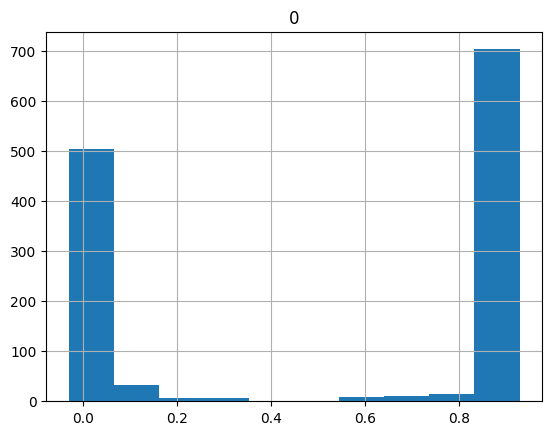

In [52]:
pd.DataFrame(y_pred).hist()

def threshold_predictions(y_pred, threshold=0.5):
    """
    Преобразует вероятности в бинарные метки с использованием порога.

    Parameters:
    - y_pred: np.ndarray
        Вектор вероятностей принадлежности к классу 1.
    - threshold: float (по умолчанию 0.5)
        Граница для преобразования вероятностей в бинарные метки.

    Returns:
    - np.ndarray
        Вектор бинарных меток (0 или 1).
    """
    pd.DataFrame(y_pred).hist()
    
    return (y_pred > threshold).astype(int)

y_pred_binary = threshold_predictions(y_pred, threshold = 0.4)

In [46]:
from sklearn.metrics import confusion_matrix, classification_report
evaluate_classification_metrics(data[y_col], y_pred, 'Blending ens_model')

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [ ]:
print_roca_auc(s1, test_X, test_y, '1-stacking')

In [ ]:
s1.predict(test_df)

In [ ]:
# test_df = test_df.astype({'channel_code': 'category', 'branch_code': 'category'})

In [ ]:
# s1 = DjStacking(trained_models, ens_model)
# a = 0
# e = []
# for t in range(2, 11):
#     s1.fit(train_X, train_y, p=-1, cv=t, err=0.00)
#     a = s1.predict(test_X, train_y)
#     auc = roc_auc_score(test_y, a)
#     print (auc)
#     e.append(auc)

In [ ]:
sample_submission_df = pd.read_csv("/kaggle/input/sibalfahack/Siberian Alfa Hack Materials/Siberian Alfa Hack Materials/sample_submission.csv")

for i in trained_models:
    if i.__class__.__name__ == CatBoostClassifier:
        
        score = i.predict_proba(test_df)[:, 1]
        sample_submission_df["score"] = score
        sample_submission_df.to_csv(f"my_submission_{i}.csv", index=False)
    else:
        clf = i
        clf.fit(x_train[x_cols], x_train[y_cols])
        score = i.predict_proba(test_df)[:, 1]
        sample_submission_df["score"] = score
        sample_submission_df.to_csv(f"my_submission_{i}.csv", index=False)
    
# score = s1.predict(test_df)
# sample_submission_df["score"] = score
# sample_submission_df.to_csv("my_submission_essemble.csv", index=False)
    

# Pipeline for ensemble